# Práctica Final: Google Play Store
Realizado por:
Andres Puente y Francisco Solano López-Bleda

----
## Planteamiento
El objetivo de este proyecto es entrenar a una red neuronal para poder predecir el rating de una aplicación basado en el input que le aportemos


## Datos

### Descripción de los datos

#### `googleplaystore.csv`
Contiene información de las aplicaciones alojadas en Google Play Store hasta el 8 de agosto de 2018. Este fichero se usará principalmente para conocer la información de la app. Nos proveerá toda la información necesaria para poder predecir el rating de una aplicación.

| App                       | Category  | Rating                  | Reviews           | Size                     | Installs                | Type                             | Price  | Content Rating          | Genres                  | Last Updated          | Current Ver     | Android Ver                         |
|---------------------------|-----------|-------------------------|-------------------|--------------------------|-------------------------|----------------------------------|--------|-------------------------|-------------------------|-----------------------|-----------------|-------------------------------------|
|  Nombre App | Categoría | Rating de la aplicación | Número de reviews |  Tamaño | Número de instalaciones | paid or free | Precio | Putuacion del contenido | Género de la aplicación |  Última actualización |  Versión actual | Mínima version de Android soportada |

#### `googleplaystore_user_reviews.csv` 
Contiene información de las reviews de las aplicaciones alojadas en Google Play Store hasta el 8 de agosto de 2018. Este fichero se podrá usar usará para poder capturar reviews falsas, así cruzando datos de este dataset y el anterior también podremos predecir el porcentaje de reviews falsas.

| App | Translated_Review | Sentiment | Sentiment_Polarity | Sentiment_Subjectivity |
|--------------------------|-------------------------|--------------------------------------|-------------------------|----------------------------|
| Nombre de la Applicación | Traducción de la review | Opinion: Positiva, Negativa o Neutra | Polaridad de la opinión | Subjetividad de la opinion |

### Gestión de los datos
De los datos propocionados por `googleplaystore.csv` serán alterados de la siguiente forma:

| Category  | Rating                  | Reviews           | Size                     | Installs                | Type                             | Price  | Content Rating          | Genres                  |
|---------------------------|-----------|-------------------------|-------------------|--------------------------|-------------------------|----------------------------------|--------|--------------------------|
| Categoría | Rating de la aplicación | Número de reviews |  Tamaño | Número de instalaciones | paid or free | Precio | Putuacion del contenido | Género de la aplicación  |


## Imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics

## Data

### Lectura de los datos - Representacion de los tipos de datos

In [2]:
data = pd.read_csv('data/googleplaystore.csv')
data = data.dropna()
data = data.reset_index(drop=True)
data.info()

dataReview = pd.read_csv('data/googleplaystore_user_reviews.csv')
dataReview.info()
dataReview = dataReview.dropna(subset=['Sentiment'])
dataReview = dataReview.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
App                       64295 non-null object
Translated_Review         37427 non-null object
Sentiment                 37432 non-null object
Sentiment_Polarity        37432 non-null float64
Sentiment_Subjectivity    3

### Lectura de los datos - Visualizacion

Visualizacion de los datos de los 5 primeros elementos

In [3]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Transformacion de los datos

Para poder llevar a cabo un buen algoritmo de machine learning transformaremos los datos a int/float cuando sea posible para generar una mejor coorrelacion entre los datos.

Aquellos datos que no se consideren necesarios o relevantes para la aproximacion seran desechados.

In [4]:
#Transformacion de las categorias a int
CategoryString = data["Category"]
categoryVal = data["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0, categoryValCount):
    category_dict[categoryVal[i]] = i
data["Category_i"] = data["Category"].map(category_dict).astype(int)

In [5]:
def sentimentTrans(sent):
    if sent == "Positive":
        return 2
    elif sent == "Neutral":
        return 1
    elif sent == "Negative":
        return 0
    return sent
dataReview["Sentiment"] = dataReview["Sentiment"].map(sentimentTrans).astype(int)

In [6]:
appNamesReview = dataReview["App"].unique()
print(appNamesReview)

['10 Best Foods for You' '104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室' '11st'
 '1800 Contacts - Lens Store' '1LINE – One Line with One Touch'
 '2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif'
 '21-Day Meditation Experience' '2Date Dating App, Love and matching'
 '2GIS: directory & navigator' '2RedBeans' '2ndLine - Second Phone Number'
 '30 Day Fitness Challenge - Workout at Home' '365Scores - Live Scores'
 '3D Live Neon Weed Launcher' '4 in a Row'
 '4K Wallpapers and Ultra HD Backgrounds'
 '591房屋交易-租屋、中古屋、新建案、實價登錄、別墅透天、公寓套房、捷運、買房賣房行情、房價房貸查詢' '591房屋交易-香港'
 '7 Cups: Anxiety & Stress Chat' '7 Day Food Journal Challenge'
 '7 Minute Workout' '7 Weeks - Habit & Goal Tracker' '8 Ball Pool'
 '850 Sports News Digest' '8fit Workouts & Meal Planner'
 '95Live -SG#1 Live Streaming App' 'A Call From Santa Claus!'
 'A Word A Day' 'A&E - Watch Full Episodes of TV Shows'
 'A+ Gallery - Photos & Videos' 'A+ Mobile' 'ABC Kids - Tracing & Phonics'
 'ABC News - US & World News' 'ABC Preschool Free' 'ABCmouse.com'
 

In [7]:
#Transformacion y limpieza del tamaño de instalacion
def sizes_trans(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None
    
data["Size"] = data["Size"].map(sizes_trans)

#Rellenando los vacios
data.Size.fillna(method = 'ffill', inplace = True)

In [8]:
#Transformacion del número de descargas(Installs)
def installs_trans(inst):
    try:
        x = (inst[:-1].replace(",",""))
        x = int(x)
        #return x
    except ValueError:
        print("Line is corrupt!", x)
        x = 0
    return x


data["Installs"] = data["Installs"].map(installs_trans)

#data["Installs"] = [(i[:-1].replace(",","")) for i in data["Installs"]]
#data["Installs"] = data["Installs"].astype(float)

In [9]:
#Transformacion del Tipo de app(Free/No Free) a binario
def type_trans(types):
    if types == 'Free':
        return 0
    else:
        return 1
    
data["Type"] = data["Type"].map(type_trans)

In [10]:
#Transformacion del "Content Rating" a enteros por cada valor unico
RatingL = data["Content Rating"].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
    
data["Content Rating"] = data["Content Rating"].map(RatingDict).astype(int)

In [11]:
#Transformacion de los "Genres" a int
GenresL = data.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
    
data["Genres_i"] = data["Genres"].map(GenresDict).astype(int)

In [12]:
#Transformar Fecha a numero
test_date = "August 2, 2018"
import datetime
def date_trans(date_str):
    date_time_obj = datetime.datetime.strptime(date_str, '%B %d, %Y')
    return date_time_obj.timestamp()
data["Last Updated"] = data["Last Updated"].map(date_trans).astype(float)

In [13]:
#Transformacion de los precios a int
def price_trans(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        if price == "veryone":
            price = 0
        price = float(price)
        return price
    
data["Price"] = data["Price"].map(price_trans).astype(float)

In [14]:
#Transformacion de las reviews a float

def review_trans(rev):
    if 'M' in rev:
        x = rev[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == rev[-1:]:
        x = rev[:-1]
        x = float(x)*1000
        return(x)
    else:
        return rev

data["Reviews"] = data["Reviews"].map(review_trans).astype(float)

In [15]:
def nameLenght(name):
    return len(name)

#data["NameL"] = data["App"].map(nameLenght).astype(int)

In [16]:
#Eliminando los parametros que no utilizaremos ya que no son relevantes
data.drop(labels = ["Last Updated","Current Ver", 'Android Ver', 'App'], axis = 1, inplace = True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 11 columns):
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null float64
Size              9360 non-null float64
Installs          9360 non-null int64
Type              9360 non-null int64
Price             9360 non-null float64
Content Rating    9360 non-null int32
Genres            9360 non-null object
Category_i        9360 non-null int32
Genres_i          9360 non-null int32
dtypes: float64(4), int32(3), int64(2), object(2)
memory usage: 767.8+ KB


In [18]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_i,Genres_i
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000,0,0.0,0,Art & Design,0,0
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000,0,0.0,0,Art & Design,0,0
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000,0,0.0,1,Art & Design,0,0
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2


## Dummies

In [19]:
data2 = pd.get_dummies(data, columns=["Category"])

In [20]:
data2.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_i,Genres_i,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,4.1,159.0,19000000.0,10000,0,0.0,0,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967.0,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510.0,8700000.0,5000000,0,0.0,0,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644.0,25000000.0,50000000,0,0.0,1,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967.0,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 43 columns):
Rating                          9360 non-null float64
Reviews                         9360 non-null float64
Size                            9360 non-null float64
Installs                        9360 non-null int64
Type                            9360 non-null int64
Price                           9360 non-null float64
Content Rating                  9360 non-null int32
Genres                          9360 non-null object
Category_i                      9360 non-null int32
Genres_i                        9360 non-null int32
Category_ART_AND_DESIGN         9360 non-null uint8
Category_AUTO_AND_VEHICLES      9360 non-null uint8
Category_BEAUTY                 9360 non-null uint8
Category_BOOKS_AND_REFERENCE    9360 non-null uint8
Category_BUSINESS               9360 non-null uint8
Category_COMICS                 9360 non-null uint8
Category_COMMUNICATION          9360 non-null uint8

## Gráficas guays

In [22]:
#Evaluacion de matriz
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

## Hace Calculos
### Excluye el genero

In [25]:
#excluding Genre label
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split



#Integer encoding
X = data.drop(labels = ['Category','Rating','Genres','Genres_i'],axis = 1)
y = data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

#Creation of results dataframe and addition of first entry
resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test,Results),orient = 'index')
resultsdf = resultsdf.transpose()

#dummy encoding

X_d = data2.drop(labels = ['Rating','Genres','Category_i','Genres_i'],axis = 1)
y_d = data2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

#adding results into results dataframe
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear - Dummy'),ignore_index = True)

#### Dibujooooos

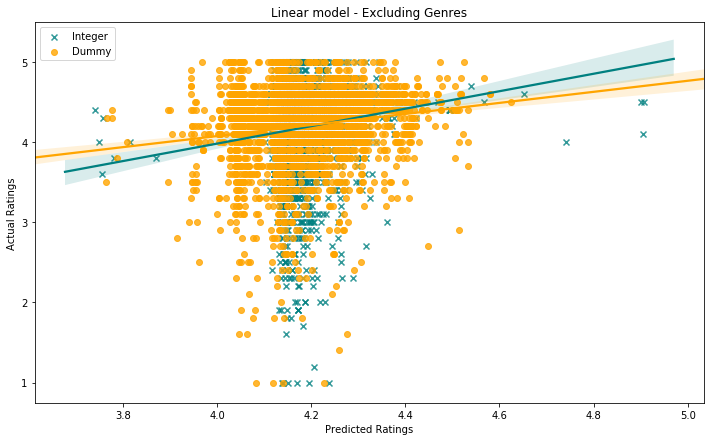

In [26]:
import seaborn as sns


plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('Linear model - Excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()



In [56]:
print ('Actual mean of population:' + str(y.mean()))
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Actual mean of population:4.191837606837612
Integer encoding(mean) :4.194180502337778
Dummy encoding(mean) :4.1960024867030485
Integer encoding(std) :0.07310465029123436
Dummy encoding(std) :0.10534576692089018


### Incluye el genero

In [24]:
#Including genre label

#Integer encoding
X = data.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results, name = 'Linear(inc Genre) - Integer'),ignore_index = True)

#dummy encoding

X_d = data2.drop(labels = ['Rating','Genres','Category_i'],axis = 1)
y_d = data2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear(inc Genre) - Dummy'),ignore_index = True)

#### Dibujoooos

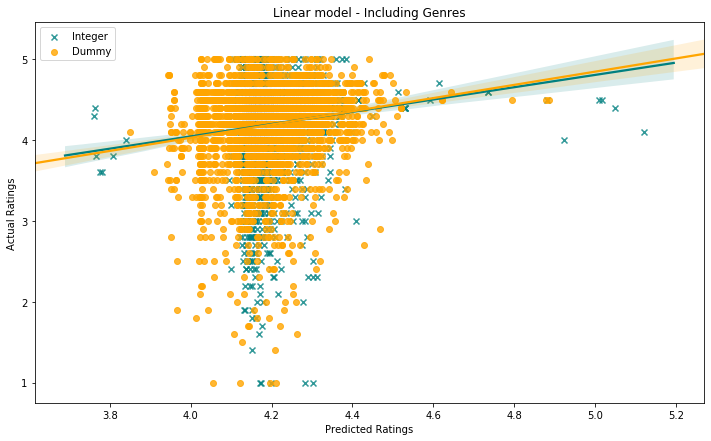

In [92]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('Linear model - Including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [27]:
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Integer encoding(mean) :4.190011893208802
Dummy encoding(mean) :4.191125136492025
Integer encoding(std) :0.05417336985216109
Dummy encoding(std) :0.10400349051122307


Texto explicando lo de arriba

## Ahora con SVR
Descripcion de lo que va a pasar

### Excluyendo Generos

In [28]:
#Excluding genres
from sklearn import svm
#Integer encoding

X = data.drop(labels = ['Category','Rating','Genres','Genres_i'],axis = 1)
y = data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train,y_train)

Results2 = model2.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results2, name = 'SVM - Integer'),ignore_index = True)

#dummy based


X_d = data2.drop(labels = ['Rating','Genres','Category_i','Genres_i'],axis = 1)
y_d = data2.Rating

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train_d,y_train_d)

Results2_d = model2.predict(X_test_d)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results2_d, name = 'SVM - Dummy'),ignore_index = True)

C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Dibujooos

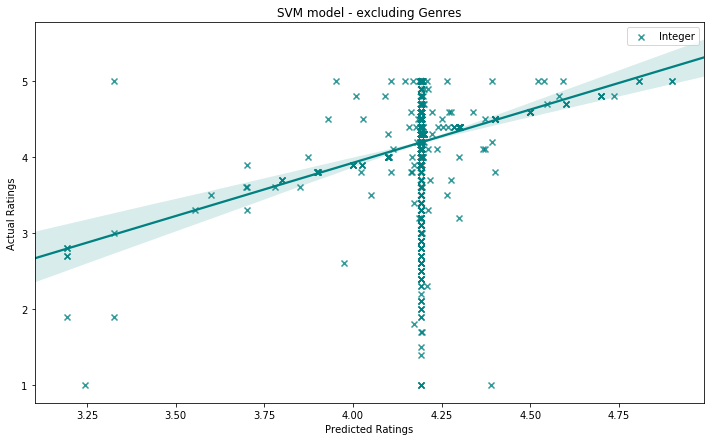

In [29]:
plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='teal', label = 'Integer', marker = 'x')
#sns.regplot(Results2_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('SVM model - excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [30]:
print ('Integer encoding(mean) :' + str(Results2.mean()))
print ('Dummy encoding(mean) :'+ str(Results2_d.mean()))
print ('Integer encoding(std) :' + str(Results2.std()))
print ('Dummy encoding(std) :'+ str(Results2_d.std()))

Integer encoding(mean) :4.1935921601956245
Dummy encoding(mean) :4.202109444557392
Integer encoding(std) :0.08261945300071111
Dummy encoding(std) :0.13600893765224734


Line is corrupt! 
Line is corrupt! Fre


C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:532: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in add


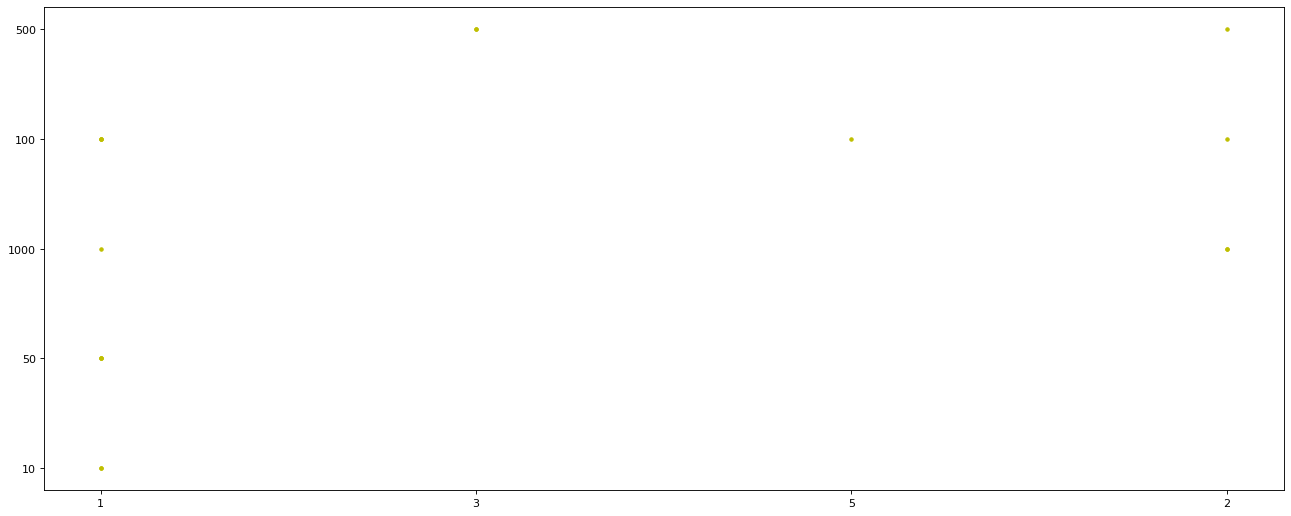

In [58]:
from scipy.optimize import fmin_tnc as tnc
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures as pf
import sys
import numpy as np
import csv
from pandas.io.parsers import read_csv
learning_rate = 1.0
POLY = 2

def poli_f(X, grado):
    poly = pf(grado)
    return poly, poly.fit_transform(X)

def J(theta, X, Y):
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    theta = np.reshape(theta, (1, n))
    v1 = np.dot(np.transpose((np.log(g(np.dot(X, np.transpose(theta)))))), Y)
    v2 = np.dot(np.transpose((np.log(1 - g(np.dot(X, np.transpose(theta)))))), (1 - Y))
    v3 = (learning_rate/(2*m)) * np.sum(theta[1:]**2)
    return (((-1/m)*(v1 + v2)) + v3)

def gradient(theta, X, Y):
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    theta = np.reshape(theta, (1, n))
    var1 = np.transpose(X)
    var2  = g(np.dot(X, np.transpose(theta)))-Y
    
    theta = np.c_[[0], theta[:, 1:]]
    var3 = (learning_rate/m) * theta
    return ((1/m) * np.dot(var1, var2)) + np.transpose(var3)

def g(z):
    """
    1/ 1 + e ^ (-0^T * x)
    """
    return 1/(1 + np.exp(-z))

def draw_data(X, Y):
    #pos = np.where(Y == 0)[0] #vector with index of the Y = 1
    #plt.scatter(X[pos, 0], X[pos, 1], marker='x', c='b')
    pos = np.where(Y == 1)[0].ravel() #vector with index of the Y = 1
    plt.scatter(X[pos, 0], X[pos, 1], marker='.', c='y')

def draw_decision_boundary(theta, X, Y, poly):
    x0_min, x0_max = X[:,0].min(), X[:,0].max()
    x1_min, x1_max = X[:,1].min(), X[:,1].max()
    xx1, xx2 = np.meshgrid(np.linspace(x0_min, x0_max), np.linspace(x1_min, x1_max))
    
    sigm = g(poly.fit_transform(np.c_[ xx1.ravel(), xx2.ravel()]).dot(theta))
    sigm = sigm.reshape(xx1.shape)

    plt.contour(xx1, xx2, sigm, [0.5], linewidths = 1, colors = 'g')

def draw(theta, X, Y, poly):
    plt.figure(figsize=(20, 8), dpi=80)
    draw_data(X, Y)
    #draw_decision_boundary(theta, X, Y, poly)
    plt.show()

def installs_trans(inst):
    try:
        x = (inst[:-1].replace(",",""))
        x = int(x)
        #return x
    except ValueError:
        print("Line is corrupt!", x)
        x = 0
    return x

def installTrans(ar):
    newAr = [0]*len(ar)
    for i in range(len(ar)):
        newAr[i] = installs_trans(ar[i])
    return newAr


def reviewTrans(ar):
    newAr = [0]*len(ar)
    for i in range(len(ar)):
        newAr[i] = review_trans(ar[i])
    return newAr



def load_csv_svm(file_name, features):
    dataFile = read_csv(file_name, header = 0)
    
    dataFile = dataFile.fillna(0)
    y = dataFile['Rating'].array
    
    X = np.array([])
    X = np.reshape(X, (len(y), 0))
    for i in range(len(features)):
        if(i==1):
            X = np.c_[X, installTrans(dataFile[features[i]].array)]
        else:
            X = np.c_[X, reviewTrans(dataFile[features[0]].array)]
        
    return X, y
    
#Hacer aqui nuestra carga de los datos
X, y = load_csv_svm("data/googleplaystore.csv", ["Reviews","Installs"])

X = np.array(X)
y = np.array(y)
y = np.reshape(y, (np.shape(y)[0], 1))

poly, X_poly = poli_f(X, POLY)
theta = np.zeros([1, np.shape(X_poly)[1]], dtype=float)

theta = tnc(func=J, x0=theta, fprime=gradient, args=(X_poly,y))[0]


draw(theta, X, y, poly)